In [7]:
from typing import Optional

import torch.distributions
import transformer_lens
from IPython.display import Image
from black.brackets import dataclass
from transformer_lens import HookedTransformer
from dataclasses import dataclass

import core

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Models
gpt2 = HookedTransformer.from_pretrained("gpt2-small")
attn_only_4l = HookedTransformer.from_pretrained("attn-only-4l")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer
Loaded pretrained model attn-only-4l into HookedTransformer


In [9]:
@dataclass
class Task:
    model: HookedTransformer
    prompt: str
    corrupted: list[str]
    correct: str
    incorrect: list[str]
    short_name: str

In [10]:
task_ioi = Task(
    model=gpt2,
    prompt="When John and Mary went to the store, John gave a book to",
    correct=" Mary",
    incorrect=[" John"],
    corrupted=["When Felix and Sarah went to the store, Diego gave a book to",
               "When Felix and Sarah went to the store, Felix gave a book to"],
    short_name="ioi",
)
task_docstring = Task(
    model=attn_only_4l,
    prompt = '''def port(self, load, size, file, last):
    """oil column piece

    :param load: crime population
    :param size: unit dark
    :param''',
    correct = " file",
    incorrect = [" last", " load", " size", " self"],
    corrupted = [],  # TODO: fill in
    short_name="docstring 1",
)
task_docstring_2 = Task(
    model=attn_only_4l,
    prompt = '''def run(place, nb, last, first):
    """run the place

    :param place: place to run
    :param nb: number of times to run
    :param''',
    correct = " first",
    incorrect = [" last", " place", " nb"],
    corrupted = [],  # TODO: fill in
    short_name="docstring 2",
)
TASKS = [task_ioi, task_docstring, task_docstring_2]

Baseline strength: 3.23


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi
When John and Mary went to the store, John gave a book to
Correct:   Mary
Incorrect:  [' John']
Intervention:  <core.ZeroPattern object at 0x7f6512b60c90>


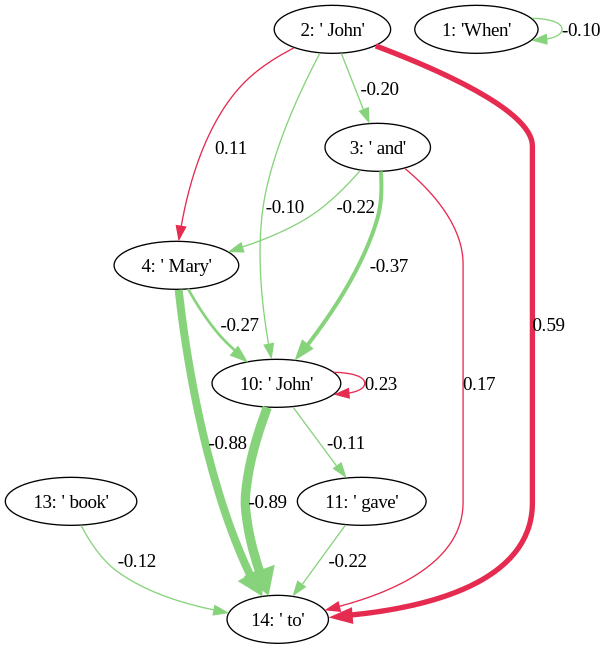

In [18]:
threshold = 0.3
top_k = 10
for task in TASKS:
    metric = core.logit_diff_metric(task.model, task.correct, *task.incorrect)
    assert metric(task.model(task.prompt)[0]) > 0.1, "The model cannot do the task"
    interventions = [
        core.ZeroPattern(),
        core.DampenIntervention(0.1),
        core.DampenIntervention(0.3),
        core.CropIntervention(task.model, task.prompt),
    ]
    for corrupted in task.corrupted:
        interventions.append(core.CorruptIntervention(task.model, task.prompt, corrupted))

    strategy = core.BasicStrategy()
    for intervention in interventions:
        connectome = core.connectom(task.model, task.prompt, metric, intervention, strategy)
        print(task.short_name)
        print(task.prompt)
        print("Correct: ", task.correct)
        print("Incorrect: ", task.incorrect)
        print("Intervention: ", intervention)
        core.plot_graphviz_connectome(task.model, task.prompt, connectome, threshold=0.09)
        break
    break
